In [1]:
import sys, os
sys.path.insert(0, os.path.abspath(".."))

# Cluster, and then flow about network


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.collections
import numpy as np
import tilemapbase
tilemapbase.start_logging()
import lzma

import opencrimedata.chicago
import opencrimedata.network
import opencrimedata.geometry
import opencrimedata.replace
import opencrimedata.tiger_lines
import opencrimedata.address

import open_cp.geometry
open_cp.geometry.configure_gdal()
import open_cp.logger
open_cp.logger.log_to_true_stdout("opencrimedata")
proj = opencrimedata.chicago.projector()

## Load input data

In [3]:
#datadir = os.path.join("/media", "disk", "Data")
datadir = os.path.join("..", "..", "..", "..", "Data")

In [4]:
def gen():
    filename = os.path.join(datadir, "chicago_all.csv.xz")
    with lzma.open(filename, "rt", encoding="utf8") as f:
        yield from opencrimedata.chicago.load_only_with_point(f)
        
points = np.asarray([row.point for row in gen() if row.datetime.year > 2001])
points = np.asarray(list(proj(*points.T))).T
points.shape

(5840574, 2)

In [5]:
ag = opencrimedata.geometry.AggregatePointsViaGraphFast(points, tolerance=20)
ag.merged_points.shape

(54388, 2)

In [6]:
wm_merged_pts = np.asarray([tilemapbase.project(*proj(*pt, inverse=True)) for pt in ag.merged_points])

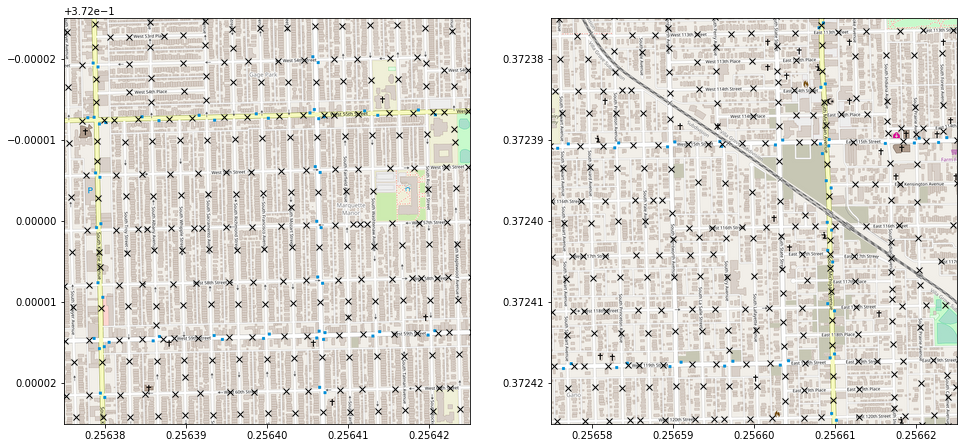

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(16,8))

ax = axes[0]
ex = tilemapbase.Extent.from_centre(0.2564, 0.372, xsize=0.00005)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=600)
plotter.plot(ax)
ax.scatter(*wm_merged_pts.T, marker="x", color="black", linewidth=1)

ax = axes[1]
ex = tilemapbase.Extent.from_centre(0.2566, 0.3724, xsize=0.00005)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=600)
plotter.plot(ax)
ax.scatter(*wm_merged_pts.T, marker="x", color="black", linewidth=1)

## Load TIGER/Lines

In [8]:
tigerdir = os.path.join(datadir, 'TIGER Data')

In [9]:
tiger_lines = opencrimedata.tiger_lines.TigerLines(
    os.path.join(tigerdir, "tl_2016_17031_roads"),
    os.path.join(tigerdir, "tl_2016_17031_edges"),
    proj)

In [10]:
graph, edge_list = tiger_lines.make_reduced_graph()

# Do the redistribution

We'll let the `Redistributor` do the initial aggregation, at 20m, as above.

In [11]:
redist = opencrimedata.network.Redistributor(graph, points, min_distance=50, max_distance=250,
                                             tolerance=1, initial_tolerance=20)

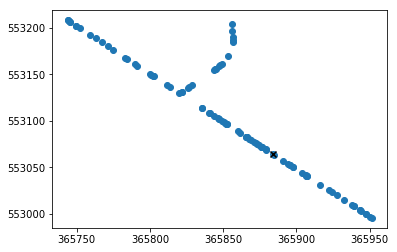

In [12]:
pts = []
for _ in range(100):
    pts.append(redist.redistribute(5))

pts = np.asarray(pts)
plt.scatter(*pts.T)

plt.scatter(*points[5], marker="x", color="black")

In [13]:
redist = opencrimedata.network.Redistributor(graph, points, min_distance=50, max_distance=250,
                                             tolerance=1, initial_tolerance=20)

class MyAssign(opencrimedata.replace.AssignNew):
    def adjust(self, row):
        pt = proj(*row.point)
        pt = redist.redistribute_from_point(pt)
        return opencrimedata.chicago.row_with_new_position(row, *proj(*pt, inverse=True))

def gen():
    filename = os.path.join(datadir, "chicago_all.csv.xz")
    with lzma.open(filename, "rt", encoding="utf8") as f:
        for row in opencrimedata.chicago.load_only_with_point(f):
            if row.datetime.year > 2001:
                yield row
    
assign = MyAssign(gen(), seed=1234)

In [14]:
filename = os.path.join(datadir, "Chicago_redist_network_flow.csv.xz")
with lzma.open(filename, "wt", newline="", encoding="UTF8") as f:
    opencrimedata.chicago.write(f, assign)

# Reload and plot

In [36]:
def gen():
    filename = os.path.join(datadir, "chicago_all.csv.xz")
    with lzma.open(filename, "rt", encoding="utf8") as f:
        for row in opencrimedata.chicago.load_only_with_point(f):
            if row.datetime.year > 2001:
                yield row
                
def gen_new():
    filename = os.path.join(datadir, "Chicago_redist_network_flow.csv.xz")
    with lzma.open(filename, "rt", encoding="utf8") as f:
        yield from opencrimedata.chicago.load_only_with_point(f)
        
points, points_new = [], []
for row, row_new in zip(gen(), gen_new()):
    assert row.id == row_new.id
    points.append(row.point)
    points_new.append(row_new.point)

In [37]:
points = [tilemapbase.project(*pt) for pt in points]
points_new = [tilemapbase.project(*pt) for pt in points_new]
points = np.asarray(points)
points_new = np.asarray(points_new)

In [38]:
fig, axes = plt.subplots(ncols=2, figsize=(16,8))

for ax in axes:
    ex = tilemapbase.Extent.from_centre(0.2564, 0.372, xsize=0.00003)
    plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=600)
    plotter.plot(ax)
axes[0].scatter(*points.T, marker="x", linewidth=1, color="black")
axes[1].scatter(*points_new.T, marker="x", linewidth=1, color="black")

## Large moves

Want to investigate cases where we seem to move points a long way...  There are actually rather few of these, but they are still worth looking at.

These are all at the airport...!

In [39]:
points_ll, points_new_ll = [], []
for row, row_new in zip(gen(), gen_new()):
    assert row.id == row_new.id
    points_ll.append(row.point)
    points_new_ll.append(row_new.point)

In [40]:
proj = opencrimedata.chicago.projector()
points_ll = proj(*np.asarray(points_ll).T)
points_ll = np.asarray(points_ll)
points_new_ll = proj(*np.asarray(points_new_ll).T)
points_new_ll = np.asarray(points_new_ll)

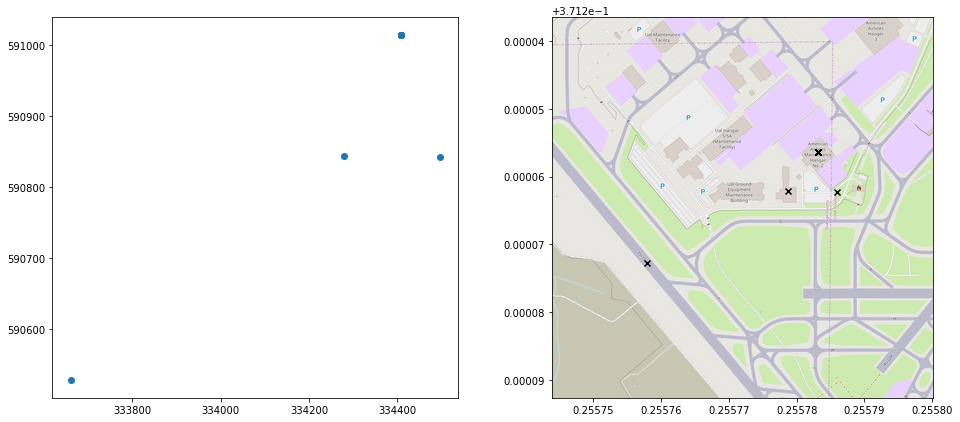

In [50]:
dist = np.sqrt(np.sum((points_ll - points_new_ll)**2, axis=0))
m = dist > 1000

fig, axes = plt.subplots(ncols=2, figsize=(16,7))
pts = points_ll[:,m]
axes[0].scatter(*pts)

pts = points[m,:]
xmax, ymax = np.max(pts, axis=0)
xmin, ymin = np.min(pts, axis=0)
d = max(xmax-xmin, ymax-ymin) * 2
ex = tilemapbase.Extent.from_centre((xmin+xmax)/2, (ymin+ymax)/2, xsize=d)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=600)
plotter.plot(axes[1])
axes[1].scatter(*pts.T, marker="x", color="black")

# Project to nearest building

In [7]:
filename = os.path.join(datadir, "openaddr-collected-us_midwest.zip")

address_matcher = opencrimedata.address.AddressMatch.from_zip(filename, "il", "cook", proj)

In [8]:
def gen1():
    filename = os.path.join(datadir, "Chicago_redist_network_flow.csv.xz")
    with lzma.open(filename, "rt", encoding="utf8") as f:
        yield from opencrimedata.chicago.load_only_with_point(f)

row = next(gen1())
row, address_matcher.closest(proj(*row.point))

(Row(id='5189091', crime_type='OFFENSE INVOLVING CHILDREN', crime_subtype='CHILD ABUSE', location='RESIDENCE', address='108XX S AVENUE G', datetime=datetime.datetime(2006, 10, 12, 10, 58), point=(-87.53143112166953, 41.69726910890651)),
 (array(['10901', 'SOUTH AVENUE G'], 
        dtype='<U40'), array([ 366757.55176995,  558774.43748541])))

In [23]:
class AssignNew(opencrimedata.replace.AssignNew):
    def adjust(self, row):
        address, pt = address_matcher.closest(proj(*row.point))
        _, points = address_matcher.all_in_disc(pt, 100)
        i = np.random.choice(len(points))
        pt = points[i]
        return opencrimedata.chicago.row_with_new_position(row, *proj(*pt, inverse=True))
    
assign = AssignNew(gen1(), seed=1234)
with lzma.open(os.path.join(datadir, "chicago_redist_network_flow_to_buildings.csv.xz"), "wt", newline="") as f:
    opencrimedata.chicago.write(f, assign)

# Plot

In [4]:
def gen():
    filename = os.path.join(datadir, "chicago_all.csv.xz")
    with lzma.open(filename, "rt", encoding="utf8") as f:
        yield from opencrimedata.chicago.load_only_with_point(f)

def gen_new():
    filename = os.path.join(datadir, "chicago_redist_network_flow_to_buildings.csv.xz")
    with lzma.open(filename, "rt") as f:
        yield from opencrimedata.chicago.load_only_with_point(f)

In [7]:
points_dict = {row.id : row.point for row in gen()}
points_dict_new = {row.id : row.point for row in gen_new()}

In [10]:
points, points_new = [], []
for key in points_dict_new:
    row = points_dict[key]
    row_new = points_dict_new[key]
    points.append(tilemapbase.project(*row))
    points_new.append(tilemapbase.project(*row_new))

points = np.asarray(points)
points_new = np.asarray(points_new)

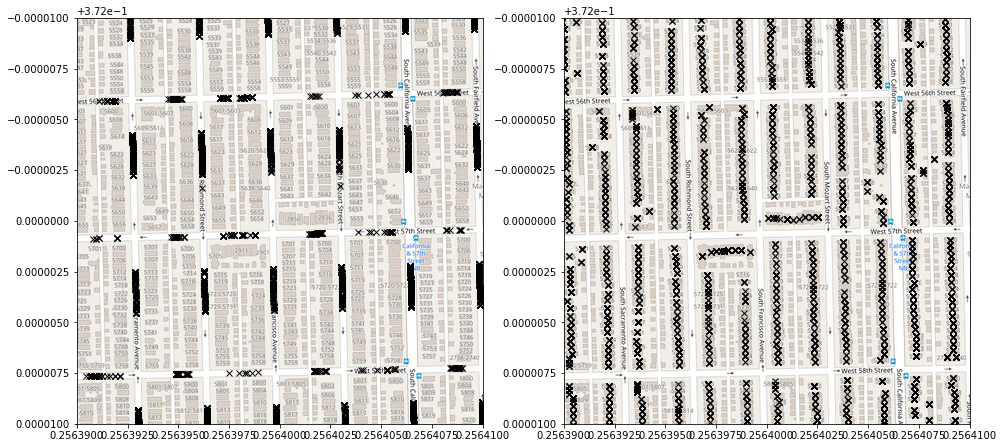

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(16,8))

for ax in axes:
    ex = tilemapbase.Extent.from_centre(0.2564, 0.372, xsize=0.00002)
    plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=600)
    plotter.plot(ax)
axes[0].scatter(*points.T, marker="x", linewidth=1, color="black")
axes[1].scatter(*points_new.T, marker="x", linewidth=1, color="black")

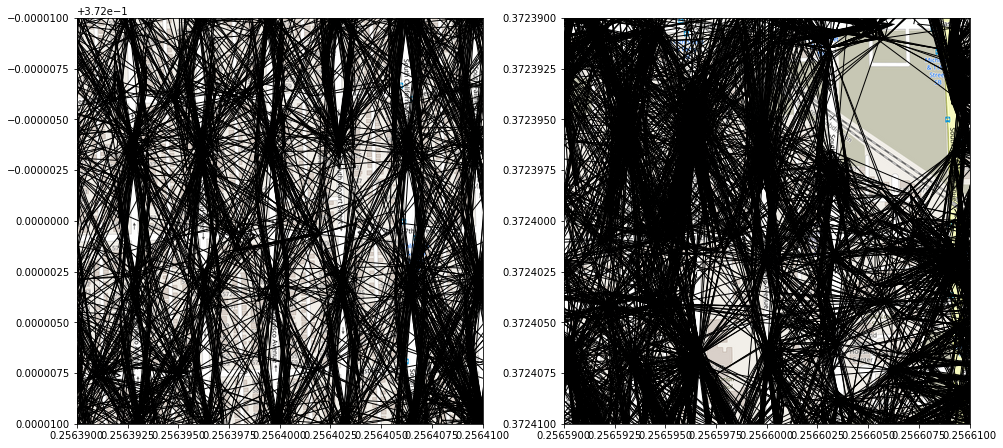

In [17]:
fig, axes = plt.subplots(ncols=2, figsize=(16,8))

ex = tilemapbase.Extent.from_centre(0.2564, 0.372, xsize=0.00002)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=600)
plotter.plot(axes[0])

ex = tilemapbase.Extent.from_centre(0.2566, 0.3724, xsize=0.00002)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=600)
plotter.plot(axes[1])

for ax in axes:
    lines = list(zip(points, points_new))
    li = matplotlib.collections.LineCollection(lines, color="black", linewidth=1)
    ax.add_collection(li)

# Redistribute using the street network

Project the _building_ points to the nearest street, and then work just on the street network.

### Project buildings to street network

In [10]:
addresses_on_network = []
for pt in address_matcher.address_points:
    edge, t = graph.project_point_to_graph(*pt)
    addresses_on_network.append(graph.edge_to_coords(*edge, t))
addresses_on_network = np.asarray(addresses_on_network)

In [11]:
matcher = opencrimedata.geometry.ClosestPoint(addresses_on_network)

In [13]:
row = next(iter(gen1()))
idxes, points = matcher.all_in_disc(proj(*row.point), 10)

In [14]:
row, address_matcher.addresses[idxes]

(Row(id='5189091', crime_type='OFFENSE INVOLVING CHILDREN', crime_subtype='CHILD ABUSE', location='RESIDENCE', address='108XX S AVENUE G', datetime=datetime.datetime(2006, 10, 12, 10, 58), point=(-87.53143112166953, 41.69726910890651)),
 array([['10857', 'SOUTH AVENUE G'],
        ['10901', 'SOUTH AVENUE G']], 
       dtype='<U40'))

In [17]:
class AssignNew(opencrimedata.replace.AssignNew):
    def adjust(self, row):
        pt = proj(*row.point)
        d = 10
        while True:
            indicies, _ = matcher.all_in_disc(pt, d)
            if len(indicies) == 0:
                d += 10
            else:
                break
        i = np.random.choice(indicies)
        pt = address_matcher.address_points[i]
        return opencrimedata.chicago.row_with_new_position(row, *proj(*pt, inverse=True))
    
assign = AssignNew(gen1(), seed=1234)
with lzma.open(os.path.join(datadir, "chicago_redist_network_flow_to_buildings_network.csv.xz"), "wt", newline="") as f:
    opencrimedata.chicago.write(f, assign)

## Reload and plot

In [4]:
def gen():
    filename = os.path.join(datadir, "chicago_all.csv.xz")
    with lzma.open(filename, "rt", encoding="utf8") as f:
        yield from opencrimedata.chicago.load_only_with_point(f)

def gen1():
    filename = os.path.join(datadir, "Chicago_redist_network_flow.csv.xz")
    with lzma.open(filename, "rt", encoding="utf8") as f:
        yield from opencrimedata.chicago.load_only_with_point(f)
        
def gen_new():
    filename = os.path.join(datadir, "chicago_redist_network_flow_to_buildings_network.csv.xz")
    with lzma.open(filename, "rt") as f:
        yield from opencrimedata.chicago.load_only_with_point(f)

In [5]:
points_dict = {row.id : row.point for row in gen()}

In [6]:
points, points_mid, points_new = [], [], []
for row_mid, row_new in zip(gen1(), gen_new()):
    assert row_mid.id == row_new.id
    points.append(tilemapbase.project(*points_dict[row_mid.id]))
    points_mid.append(tilemapbase.project(*row_mid.point))
    points_new.append(tilemapbase.project(*row_new.point))
points = np.asarray(points)
points_mid = np.asarray(points_mid)
points_new = np.asarray(points_new)

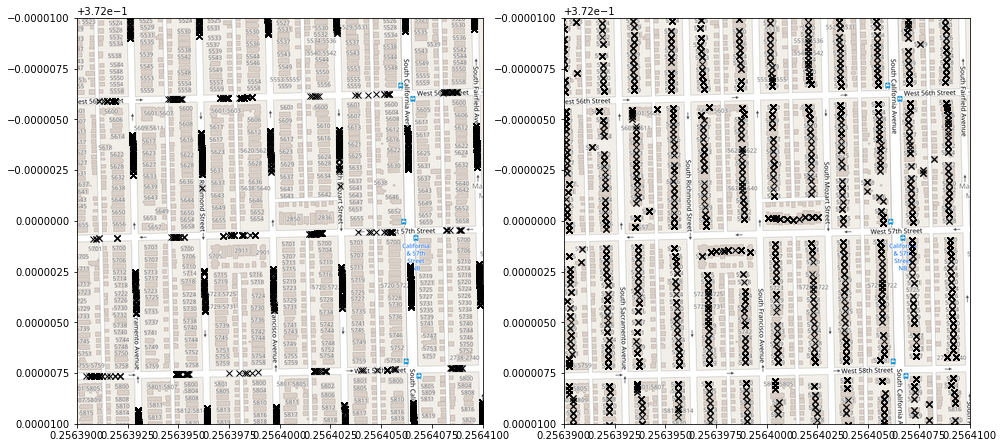

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(16,8))

for ax in axes:
    ex = tilemapbase.Extent.from_centre(0.2564, 0.372, xsize=0.00002)
    plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=600)
    plotter.plot(ax)
axes[0].scatter(*points.T, marker="x", linewidth=1, color="black")
axes[1].scatter(*points_new.T, marker="x", linewidth=1, color="black")

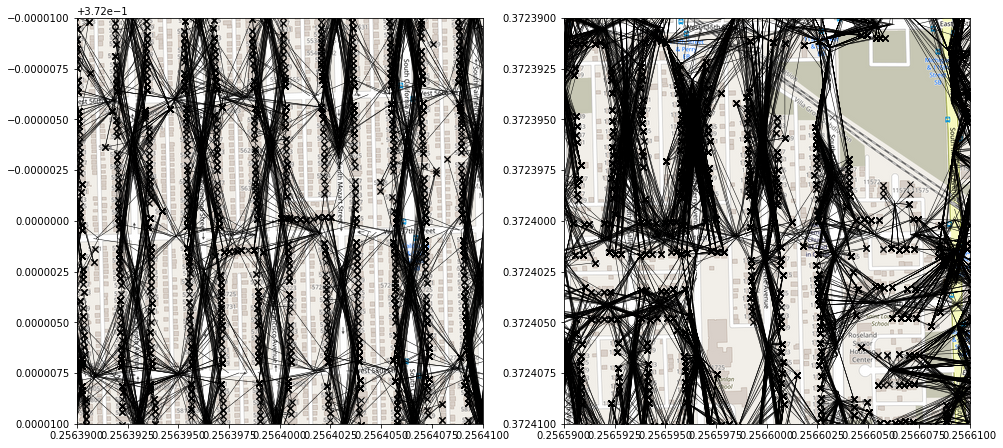

In [8]:
def get_lines(ex):
    x, y = (ex.xmin + ex.xmax) / 2, (ex.ymin + ex.ymax) / 2
    d = max(ex.width, ex.height) * 10
    lines = []
    for pt1, pt2 in zip(points, points_new):
        in1 = x-d <= pt1[0] <= x+d and y-d <= pt1[1] <= y+d
        in2 = x-d <= pt2[0] <= x+d and y-d <= pt2[1] <= y+d
        if in1 or in2:
            lines.append((pt1, pt2))
    return lines
            
fig, axes = plt.subplots(ncols=2, figsize=(16,8))

ax = axes[0]
ex = tilemapbase.Extent.from_centre(0.2564, 0.372, xsize=0.00002)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=600)
plotter.plot(ax)
li = matplotlib.collections.LineCollection(get_lines(ex), color="black", linewidth=0.5)
ax.add_collection(li)

ax = axes[1]
ex = tilemapbase.Extent.from_centre(0.2566, 0.3724, xsize=0.00002)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=600)
plotter.plot(ax)
li = matplotlib.collections.LineCollection(get_lines(ex), color="black", linewidth=0.5)
ax.add_collection(li)

for ax in axes:
    ax.scatter(*points_new.T, marker="x", linewidth=1, color="black")

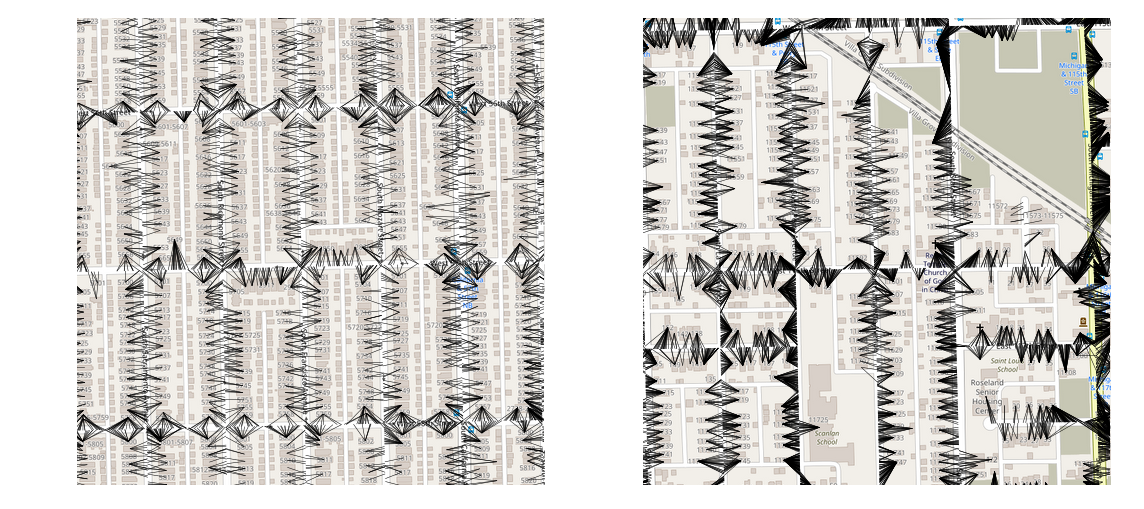

In [9]:
def get_lines(ex):
    x, y = (ex.xmin + ex.xmax) / 2, (ex.ymin + ex.ymax) / 2
    d = max(ex.width, ex.height) * 10
    lines = []
    for pt1, pt2 in zip(points_mid, points_new):
        in1 = x-d <= pt1[0] <= x+d and y-d <= pt1[1] <= y+d
        in2 = x-d <= pt2[0] <= x+d and y-d <= pt2[1] <= y+d
        if in1 or in2:
            lines.append((pt1, pt2))
    return lines
            
fig, axes = plt.subplots(ncols=2, figsize=(16,8))

ex = tilemapbase.Extent.from_centre(0.2564, 0.372, xsize=0.00002)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=600)
plotter.plot(axes[0])
li = matplotlib.collections.LineCollection(get_lines(ex), color="black", linewidth=0.5)
axes[0].add_collection(li)

ex = tilemapbase.Extent.from_centre(0.2566, 0.3724, xsize=0.00002)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=600)
plotter.plot(axes[1])
li = matplotlib.collections.LineCollection(get_lines(ex), color="black", linewidth=0.5)
axes[1].add_collection(li)

for ax in axes:
    ax.set_axis_off()
fig.tight_layout()

In [10]:
fig.savefig("chicago_buildings_after_flow.png", dpi=150)

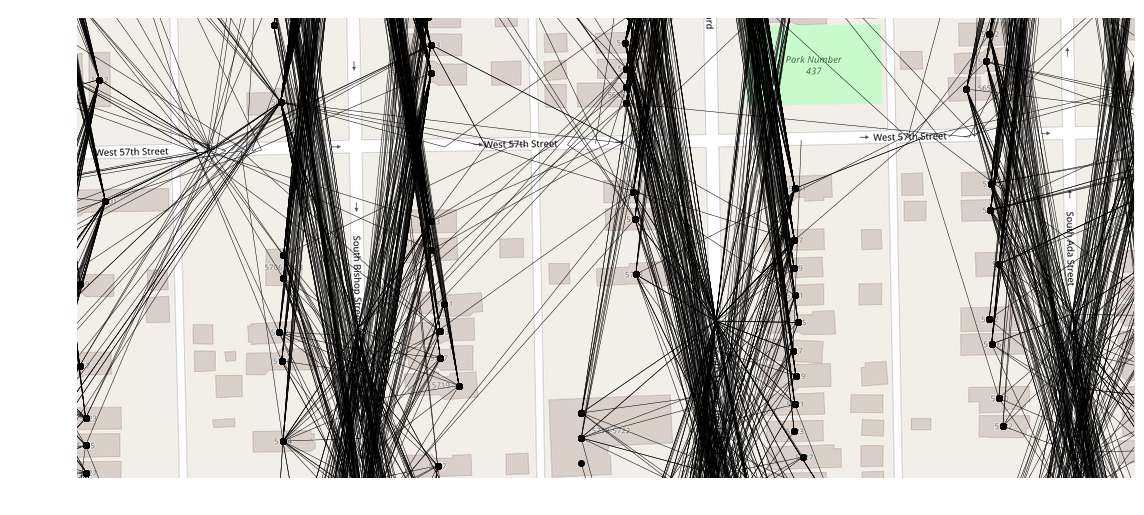

In [11]:
def get_lines(ex):
    x, y = (ex.xmin + ex.xmax) / 2, (ex.ymin + ex.ymax) / 2
    d = max(ex.width, ex.height) * 10
    lines = []
    for pt1, pt2 in zip(points, points_new):
        in1 = x-d <= pt1[0] <= x+d and y-d <= pt1[1] <= y+d
        in2 = x-d <= pt2[0] <= x+d and y-d <= pt2[1] <= y+d
        if in1 or in2:
            lines.append((pt1, pt2))
    return lines

x, y = 0.2565, 0.372
ex = tilemapbase.Extent.from_centre(x, y, xsize=0.00001, aspect=2.3)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=800)

fig, ax = plt.subplots(figsize=(16,8))
plotter.plot(ax)
#ax.scatter(*old_wm_pts.T, marker="x", color="black", linewidth=1, alpha=1)
ax.scatter(*points_new.T, marker="o", color="black", linewidth=1, alpha=1)

ax.add_collection(matplotlib.collections.LineCollection(get_lines(ex), color="black", linewidth=0.5))
ax.set_axis_off()
fig.tight_layout()